In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from scipy import interpolate
from scipy.optimize import newton
from SED_Funcs_custom import MagsToFluxes, InitializeExtinction
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
#######################################################################################
# Load in SED data

# Input observed magnitudes
magfile = 'hd219666_magnitudes'

# Convert magnitudes to fluxes
bandwavs_eff, bandwidths_eff, bandfluxes, bandfluxerrs, bandnames = MagsToFluxes(magfile, Teff=5527.)

# Create dictionary of observed info
sed_obs_dict = {
    'bands': bandnames,
    'band_wavelengths':bandwavs_eff,
    'band_widths':bandwidths_eff,
    'band_fluxes':bandfluxes,
    'band_fluxerrs':bandfluxerrs
}

# Initialize interstellar extinction model
ExtinctionBase = InitializeExtinction(sed_obs_dict)

# Input model stellar spectra
specprefix = '/home/mmmurphy/data/hd219666b/stellar_models/bt-settl-cifist/lte0'
specnames = ['50','51','52','53','54','55','56','57','58','59','60']
specsuffix = '.0-4.5-0.0a+0.0.BT-Settl.spec.7.dat.txt'
modelfiles = np.asarray([(specprefix+name+specsuffix) for name in specnames])

# Teffs in [K] for which model spectra were generated
# All generated with log g = 4.5 (cgs) and metallicity = 0
modeltemps = np.asarray([5000.,5100.,5200.,5300.,5400.,5500.,5600.,5700.,5800.,5900.,6000.])

modelwavs = []
modelfluxes = []
for file in modelfiles:
    modeldata =  np.loadtxt(file, unpack=True, skiprows=8, usecols=[0,1]) 
    wavs = modeldata[0]      # wavelength [angstrom]
    flux = modeldata[1]      # flux [erg / cm2 / s / angstrom]
            
    modelwavs.append(wavs)
    modelfluxes.append(flux)
            
modelwavs = np.asarray(modelwavs)
modelfluxes = np.asarray(modelfluxes)

# Extract model fluxes only in our bands
Nmodels = modelwavs.shape[0]
Nbands = sed_obs_dict['bands'].shape[0]
band_modelfluxes = [] # List of lists; For each band, gives the flux as function of model Teff

for band in range(Nbands):
    bandwav = sed_obs_dict['band_wavelengths'][band]  # effective band wavelength [micron]
    bandwav *= 1.e4  # convert to angstron
    bandwidth = sed_obs_dict['band_widths'][band]     # effective band width [micron]
    bandwidth *= 1.e4
    
    # boundary wavelengths [angstrom] of the band
    startwav = bandwav - 0.5*bandwidth
    endwav = bandwav + 0.5*bandwidth
    
    # For this band, contains flux as function of temperature (i.e. model)
    fluxesinband = np.asarray([])
    
    for model in range(Nmodels):
    
        # wavelengths & flux/wav at this Teff
        mwavs = modelwavs[model]
        mflux = modelfluxes[model]
    
        # indices corresponding to the band
        startwav_idx = np.searchsorted(mwavs, startwav, side='left') - 1
        endwav_idx = np.searchsorted(mwavs, endwav, side='left') - 1
        
        # Pull out flux/wave for this band
        modelbandfluxes = mflux[startwav_idx:endwav_idx]  # fluxes in [erg / cm2 / s / Angstrom]
        modelbandwaves = mwavs[startwav_idx:endwav_idx]
        
        # Integrate over the band
        meanmodelbandflux = np.mean(modelbandfluxes*modelbandwaves)      
        bandintegratedflux = meanmodelbandflux            # this is now in [erg / cm2 / s]
        
        fluxesinband = np.append(fluxesinband, bandintegratedflux)
    
    band_modelfluxes.append(fluxesinband)
    
band_modelfluxes = np.asarray(band_modelfluxes)

# Generate interpolation function for each band
InterpFuncs = {}

for band in range(Nbands):
    bandname = sed_obs_dict['bands'][band]
    
    band_interpfunc = interpolate.interp1d(modeltemps, band_modelfluxes[band], kind='linear')  
    InterpFuncs[bandname] = band_interpfunc


In [3]:
# Custom scaling errors 
#bandfluxerrs *= 2.2883350469133057

In [3]:
# # Orbital & Planetary Parameters
# lit_tc = 2458329.1996  # [day; bjd tdb]
# lit_P = 6.034460       # [day]
# lit_rprs = 0.04192       # [Rstar]
# lit_a = 13.27          # [Rstar]
# lit_i = 86.38          # [degrees]
lit_Rp = 4.71          # [Rearth]

# # RV parameters
# lit_K = 6.17           # [m/s]
# lit_e = 0.
# lit_w = 90.*(np.pi/180.)  # [radian]
# lit_par1 = np.sqrt(lit_e)*np.cos(lit_w)         
# lit_par2 = np.sqrt(lit_e)*np.sin(lit_w)
# lit_gamma = -20.0976   # [km/s]
lit_Mp = 16.6          # [Mearth]

# Stellar parameters
lit_Teff = 5527.       # [K]
lit_Rstar = 1.03       # [Rsol]
lit_Mstar = 0.92       # [Msol]
lit_plx = 10.6224      # [mas]
lit_Av = 0.1           # [mag]

# # HST systematics
# Hamp1_init = 0.0017220518249377167
# Htau1_init = 0.0038749871042222765
# Hamp2_init = 0.0014786496944103468
# Htau2_init = 0.00496319922916015

# Setting up parameter arrays
theta_init = np.asarray([
    # SED parameters
    lit_Teff,                    # 0 - Effective Stellar Temperature
    lit_Rstar,                   # 1 - Stellar radius
    lit_plx,                     # 2 - Parallax
    lit_Av,                      # 3 - V band extinction
])

param_labels = np.asarray([
    'Teff', 'Rstar', 'parallax', 'Av'
])




priors = np.asarray([
    # SED parameters
    lit_Teff,                    # 0 - Effective Stellar Temperature
    np.inf,                      # 1 - Stellar radius
    lit_plx,                     # 2 - Parallax
    np.inf                      # 3 - V band extinction
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # SED parameters
    65.,                                              # 0 - Effective Stellar Temperature
    0.03,                                             # 1 - Stellar radius
    0.0121,                                           # 2 - Parallax
    0.01                                             #  3 - V band extinction
])

In [4]:
#################################################
# Astrophysical Models

def stellarSED(theta, bands, InterpFuncs, ExtinctionBase):
    # Unpack parameters
    Teff = theta[0]      # Effective temperature [K]
    Rstar = theta[1]     # Stellar radius [Rsol]
    plx = theta[2]       # Parallax [milli arcsec]
    Av = theta[3]        # V-band extinction [mag]
    
    # compute distance to star in [pc]
    d_pc = 1000. / plx
    #print('Distance in parsec = ', d_pc)
    
    # Convert stellar radius to [pc]
    Rstar_pc = Rstar*2.2555823856078e-8
    
    # Compute distance & radius factor
    r2d2 = (Rstar_pc / d_pc)**2
    
    # Compute extinction attenuation factor
    tau = (ExtinctionBase)*Av
    extinction = np.exp(-tau)
    
    # Compute model energies for each band
    band_modelfluxes = np.zeros(len(bands))
    for i in range(len(bands)):
        band = bands[i]
        band_modelfluxes[i] = InterpFuncs[band](Teff)
        
    # Attenuate by radius/distance
    band_modelfluxes *= r2d2
    
    # Attenuate by extinction
    band_modelfluxes *= extinction
    
    return band_modelfluxes

In [5]:
#########################################3
# Systematic error models


In [6]:
############################################
# Bayesian functions

def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    if not (5000. <= theta[0] <= 6000.):
        # Limit Teff to interpolation range
        return -np.inf
    if not (0. < theta[3]):
        # Limit Av to be positive
        return -np.inf
    
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

In [7]:
###############################################3
# Full model wrapper functions


def model_SED(theta, sed_dict, InterpolationFunctions, Extinction):
    # compute SED model
    model_SED = stellarSED(theta, sed_dict['bands'], InterpolationFunctions, Extinction)
    
    return model_SED

In [8]:
def lnPosterior(theta, 
               flux_SED, err_SED,
               priors, priorserr,
               sed_dict, InterpolationFuncs, ExtinctionBase,
               ):
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, priors, priorserr)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    modelSED = model_SED(theta, sed_dict, InterpolationFuncs, ExtinctionBase)
    
    # Compute likelihoods
    lnLikelihood_SED = logLikelihood(flux_SED, err_SED, modelSED)
    
    lnLikelihood_value = lnLikelihood_SED

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood_value
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

In [9]:
###############################################
# Computing test models using Literature values

# Computing models
modelSED = model_SED(theta_init, sed_obs_dict, InterpFuncs, ExtinctionBase)
    
lnPosterior_initvalue = lnPosterior(theta_init,
                                    bandfluxes, bandfluxerrs,
                                    priors, priorserr,
                                    sed_obs_dict, InterpFuncs, ExtinctionBase,
                                    )

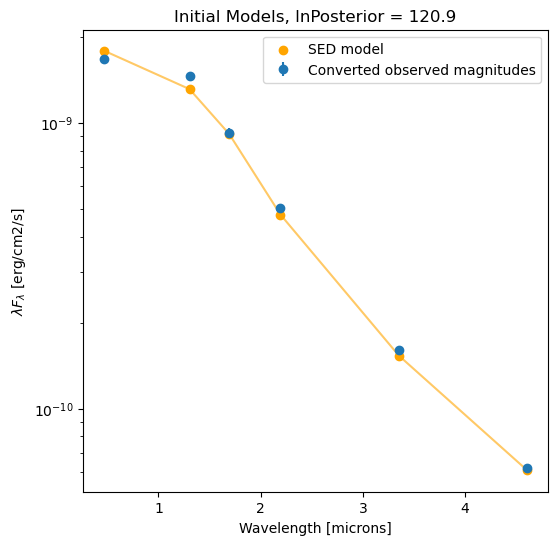

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(6,6))

ax.set_title('Initial Models, lnPosterior = %.1f'%(lnPosterior_initvalue))

ax.plot(bandwavs_eff, modelSED, c='orange', alpha=0.6)
ax.scatter(bandwavs_eff, modelSED, color='orange', label='SED model')
ax.errorbar(bandwavs_eff, bandfluxes, bandfluxerrs, ls='None', marker='o', label='Converted observed magnitudes')
ax.set_yscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'$\lambda F_\lambda$ [erg/cm2/s]')
ax.legend(loc='best');
plt.show()

In [15]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions

rerun = False
storeVals = False
saveVals = False
loadChains = not rerun

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

for i in range(Ndimensions):
    pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
    
Nsteps = 100000
burn = 1000
logParguments = [bandfluxes, bandfluxerrs,
                priors, priorserr,
                sed_obs_dict, InterpFuncs, ExtinctionBase,
                ]



In [16]:
if rerun:
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, args=logParguments, pool=pool)
        sampler.run_mcmc(pos, Nsteps, progress=True);

In [17]:
if rerun:
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)
    loglikelihoods = sampler.get_log_prob(flat=True)
    autocorrtimes = sampler.get_autocorr_time()

    
    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]
    loglikelihoods = loglikelihoods[burn*Nwalkers:]
elif loadChains:
    path = '/home/mmmurphy/data/hd219666b/mcmc_results/jointfit/'
    sfile = path+'SEDsamples_100ksteps.npy'
    ffile = path+'SEDflatsamples_100ksteps.npy'
    tfile = path+'SEDautocorrtimes_100ksteps.npy'
    samples = np.load(sfile)
    flatsamples = np.load(ffile)
    autocorrtimes = np.load(tfile)
    print('chains loaded in from ', path)
    
param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

param_fiterrs = np.asarray([])
for idx, val in enumerate(param_fits):
    param_fiterrs = np.append(param_fiterrs, np.mean([param_uperrs[idx], param_loerrs[idx]]))

# Stellar SED
fitmodelSED = model_SED(param_fits, sed_obs_dict, InterpFuncs, ExtinctionBase)
residuals_sed = bandfluxes - fitmodelSED
residual_std_sed = np.std(residuals_sed)
meanerror_sed = np.mean(bandfluxerrs)
    
# Computing ln Posterior of best fit parameter array
lnPosterior_fitvalue = lnPosterior(param_fits,
                                    bandfluxes, bandfluxerrs,
                                    priors, priorserr,
                                    sed_obs_dict, InterpFuncs, ExtinctionBase,
                                    )

if saveVals:
    path = '/home/mmmurphy/data/hd219666b/mcmc_results/jointfit/'
    sfile = path+'SEDsamples_100ksteps.npy'
    ffile = path+'SEDflatsamples_100ksteps.npy'
    tfile = path+'SEDautocorrtimes_100ksteps.npy'
    np.save(sfile, samples)
    np.save(ffile, flatsamples)
    np.save(tfile, autocorrtimes)
    print('chains saved to ', path)

chains loaded in from  /home/mmmurphy/data/hd219666b/mcmc_results/jointfit/


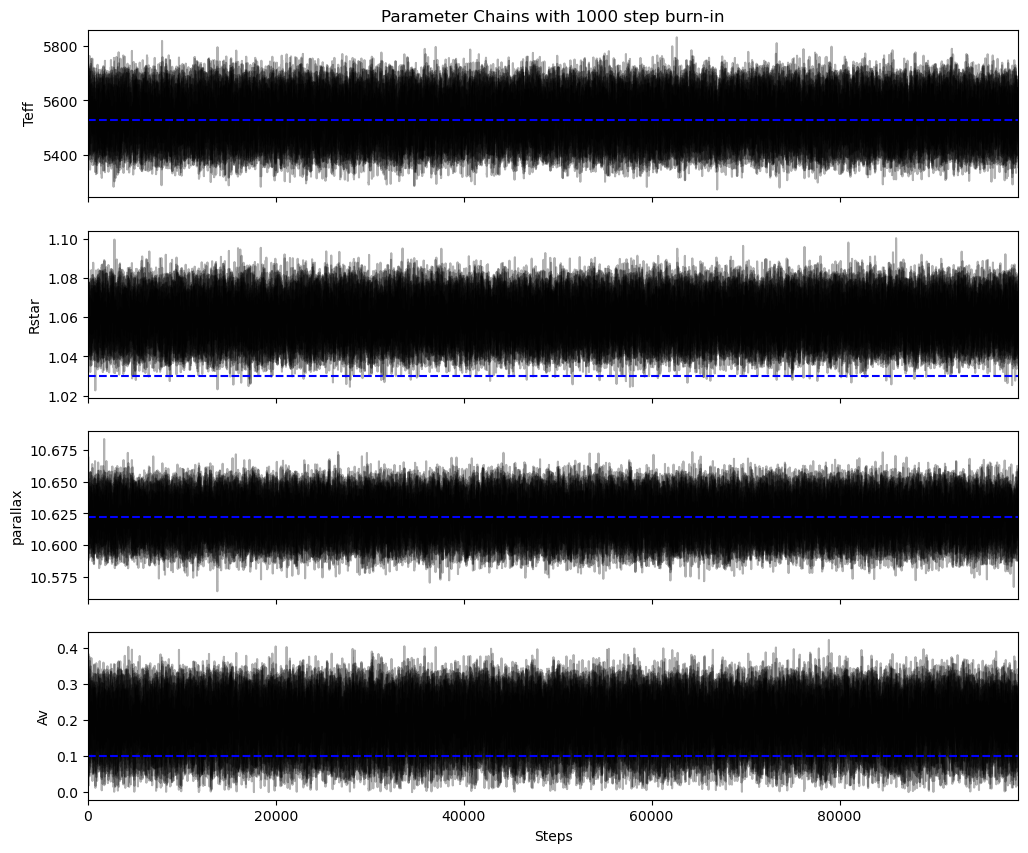

In [19]:
fig, axes = plt.subplots(samples.shape[2], figsize=(12,10), sharex=True)
for i in range(samples.shape[2]):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.axhline(theta_init[i], c='blue', ls='--')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_labels[i])
axes[0].set_title('Parameter Chains with %d step burn-in'%burn)
axes[-1].set_xlabel('Steps')
#plt.savefig('figures/SEDchains.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Setting up table of parameter fit values
from tabulate import tabulate
l = []
headers = np.asarray(['Parameter', 'Median Value', 'Uncertainty', 'Initial (Literature) Value'])
for i, val in enumerate(param_labels):
    new = [param_labels[i], param_fits[i], param_fiterrs[i], theta_init[i]]
    l.append(new)
table_params = tabulate(l, headers, tablefmt='pretty')

print("Fitting Parameters")
print(table_params)

print('Residual Statistics')
resid_table_labels = np.asarray(['SED [erg/cm2/s]'])
resid_stdvals = np.asarray([residual_std_sed])
meanerrvals = np.asarray([meanerror_sed])

l = []
headers = np.asarray(['Set', 'Residual Standard Deviation', 'Mean Data Uncertainty', 'Ratio'])
for i, val in enumerate(resid_table_labels):
    l.append([resid_table_labels[i], resid_stdvals[i], meanerrvals[i], resid_stdvals[i]/meanerrvals[i]])
table_residstats = tabulate(l, headers, tablefmt='pretty')

print(table_residstats)

Fitting Parameters
+-----------+---------------------+----------------------+----------------------------+
| Parameter |    Median Value     |     Uncertainty      | Initial (Literature) Value |
+-----------+---------------------+----------------------+----------------------------+
|   Teff    |  5539.645894842202  |  63.10762588307034   |           5527.0           |
|   Rstar   | 1.0594865830281115  | 0.008232127314753312 |            1.03            |
| parallax  | 10.622468774236943  | 0.012023401906806619 |          10.6224           |
|    Av     | 0.19425144892977353 | 0.05206095381690286  |            0.1             |
+-----------+---------------------+----------------------+----------------------------+
Residual Statistics
+-----------------+-----------------------------+-----------------------+-------------------+
|       Set       | Residual Standard Deviation | Mean Data Uncertainty |       Ratio       |
+-----------------+-----------------------------+--------------------

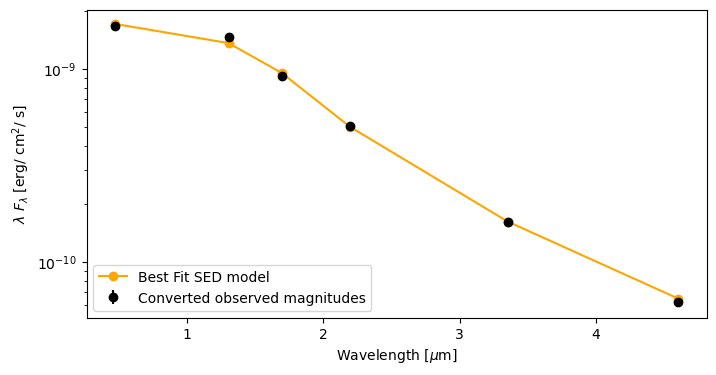

In [21]:
fig, ax = plt.subplots(figsize=(8,4), nrows=1)
ax.errorbar(bandwavs_eff, bandfluxes, bandfluxerrs, ls='None', c='black', marker='o', label='Converted observed magnitudes')
ax.plot(bandwavs_eff, fitmodelSED, color='orange', marker='o', label='Best Fit SED model')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'$\lambda~ F_\lambda$ [erg/ cm$^2$/ s]')
ax.legend(loc='lower left', fontsize=10);
#plt.savefig('figures/SEDfit.png', dpi=400, bbox_inches='tight')
plt.show()

In [22]:
loadJF = True
if loadJF:
    path = '/home/mmmurphy/data/hd219666b/mcmc_results/jointfit/'
    #jf_samples = np.load(path+'samples_49ksteps.npy')
    jf_fsamples = np.load(path+'flatsamples_50ksteps.npy')[-flatsamples.shape[0]:,:]

In [29]:
## best fit values from joint BB + TESS + RV fit
##    to calculate derived params

# Computing derived quantities from the sample chains

def get_derived_values(valuechain):
    fitvalue = np.median(valuechain)
    fiterror = np.mean([(np.percentile(valuechain, 84) - fitvalue), (fitvalue - np.percentile(valuechain, 16))])
    return fitvalue, fiterror

# time of conjunction [day]

# orbital period [day]
P_chain = 10.**(jf_fsamples[:,1])
fit_P, err_P = get_derived_values(P_chain)

# semi-major axis [Rstar]
a_chain = 10.**(jf_fsamples[:,2])
fit_a, err_a = get_derived_values(a_chain)

# inclination [degrees]
inc_chain = np.arccos(jf_fsamples[:,3])*180./np.pi
fit_inc, err_inc = get_derived_values(inc_chain)

# eccentricity
fit_e = 0.

# argument of periastron [deg]
fit_w = 90.

# rp/rstar in HST band 
rprs_hst_chain = jf_fsamples[:,4]
fit_rprs_hst, err_rprs_hst = get_derived_values(rprs_hst_chain)

# rp/rstar in tess band 
rprs_tess_chain = jf_fsamples[:,11]
fit_rprs_tess, err_rprs_tess = get_derived_values(rprs_tess_chain)

# RV semi-amplitude [m/s]
K_chain = jf_fsamples[:,14]
fit_K, err_K = get_derived_values(K_chain)

# RV system amplitude [km/s]
gamma_chain = jf_fsamples[:,15]
fit_gamma, err_gamma = get_derived_values(gamma_chain)

# Star effective temperature [K]
Teff_chain = flatsamples[:,0]
fit_Teff, fit_Teff_err = get_derived_values(Teff_chain)

# Star radius [Rsol]
Rstar_chain = flatsamples[:,1]
fit_Rstar, fit_Rstar_err = get_derived_values(Rstar_chain)

## to do - 
## once i get chains for a, P, etc
## change below code to use them instead of just fit values
# Star density [rho_sol]
prefactor = (365.25**2)/(215.**3)
rhostar_chain = prefactor*(a_chain**3)/(P_chain**2)
fit_rhostar, fit_rhostar_err = get_derived_values(rhostar_chain)

# Star mass [Msol]
Mstar_chain = rhostar_chain*(Rstar_chain**3)
fit_Mstar, fit_Mstar_err = get_derived_values(Mstar_chain)

# Planet radius in HST band
rphst_chain = rprs_hst_chain * Rstar_chain  # computes Rp in units [Rstar]
rphst_chain *= 109.076                         # converts Rp to units [Rearth]; 1 Rsun = 109.076 Rearth
fit_Rphst, fit_Rphst_err = get_derived_values(rphst_chain)

# Planet radius in tess band
rptess_chain = rprs_tess_chain * Rstar_chain  # computes Rp in units [Rstar]
rptess_chain *= 109.076                         # converts Rp to units [Rearth]; 1 Rsun = 109.076 Rearth
fit_Rptess, fit_Rptess_err = get_derived_values(rptess_chain)

# Planet mass [Mearth]
G = 1.90809e5     # [Rsun * Msun^-1 * km^2/s^2]
k_kms = K_chain / 1000.         # converts to [km/s]
a_rsun = a_chain * Rstar_chain  # converts to [Rsol]
sini = np.sin(inc_chain*(np.pi/180.))
Mp_chain = (k_kms / sini)*np.sqrt((a_rsun*(1. - fit_e**2))/G)*np.sqrt(Mstar_chain)  # computes Mp in units [Msun]
Mp_chain *= 332946.0487         # converts Mp to units [Mearth]
fit_Mp, fit_Mp_err = get_derived_values(Mp_chain)

# Planet gravity (m/s^2)
G_mks = 6.67e-11 # N * m^2 / kg^2
Mp_chain_kg = Mp_chain * 5.972e24
rphst_chain_meters = rphst_chain * 6.378e6
g_hst_chain = G_mks * Mp_chain_kg / (rphst_chain_meters**2)
fit_g_hst, fit_g_hst_err = get_derived_values(g_hst_chain)



# Parallax [mas]
plx_chain = flatsamples[:,2]
fit_plx, fit_plx_err = get_derived_values(plx_chain)

# V band extinction [mag]
Av_chain = flatsamples[:,3]
fit_Av, fit_Av_err = get_derived_values(Av_chain)

deriv_fits = np.asarray([fit_Rphst, fit_Rptess, fit_Mp, fit_g_hst,
                         fit_Teff, fit_Rstar, fit_Mstar, fit_plx, fit_Av])

deriv_fiterrs = np.asarray([fit_Rphst_err, fit_Rptess_err, fit_Mp_err, fit_g_hst_err,
                            fit_Teff_err, fit_Rstar_err, fit_Mstar_err, fit_plx_err, fit_Av_err])

deriv_labels = np.asarray(['HST Rp [Rearth]', 'TESS Rp [Rearth]', 'Mp [Mearth]', 'g [m/s^2]',
                          'Teff [K]', 'Rstar [Rsol]', 'Mstar [Msol]', 'parallax [mas]', 'Av [mag]'])


deriv_lit = np.asarray([lit_Rp, lit_Rp, lit_Mp, (G_mks*(lit_Mp*5.972e24)/((lit_Rp*6.378e6)**2)),
                       lit_Teff, lit_Rstar, lit_Mstar, lit_plx, lit_Av])

deriv_lit_errs = np.asarray([0.17, 0.17, 1.3, 0.,
                             65., 0.03, 0.03, 0.0121, 0.])

l = []
headers = np.asarray(['Quantity', 'Median Value', 'Mean Uncertainty', 'Literature/Initial Value', 'Literature Uncertainty'])
for i, val in enumerate(deriv_labels):
    new = [deriv_labels[i], deriv_fits[i], deriv_fiterrs[i], deriv_lit[i], deriv_lit_errs[i]]
    l.append(new)
table_derived = tabulate(l, headers, tablefmt='pretty')

print("Fitting Parameters")
print(table_params)
print(' ')
print("Derived System Quantities")
print(table_derived)
print('notes:')
print('planetary g computed using our HST radius')

Fitting Parameters
+-----------+---------------------+----------------------+----------------------------+
| Parameter |    Median Value     |     Uncertainty      | Initial (Literature) Value |
+-----------+---------------------+----------------------+----------------------------+
|   Teff    |  5539.645894842202  |  63.10762588307034   |           5527.0           |
|   Rstar   | 1.0594865830281115  | 0.008232127314753312 |            1.03            |
| parallax  | 10.622468774236943  | 0.012023401906806619 |          10.6224           |
|    Av     | 0.19425144892977353 | 0.05206095381690286  |            0.1             |
+-----------+---------------------+----------------------+----------------------------+
 
Derived System Quantities
+------------------+---------------------+----------------------+--------------------------+------------------------+
|     Quantity     |    Median Value     |   Mean Uncertainty   | Literature/Initial Value | Literature Uncertainty |
+------------